In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.sparse as sp
import optuna
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import GradientBoostingClassifier

test_dataset = '/kaggle/input/mai-ml-lab-2-fiit-2025/test_c.csv'
train_dataset = '/kaggle/input/mai-ml-lab-2-fiit-2025/train_c.csv'
ex_dataset = '/kaggle/input/mai-ml-lab-2-fiit-2025/ex_c.csv'

train_data = pd.read_csv(train_dataset)
test_data = pd.read_csv(test_dataset)

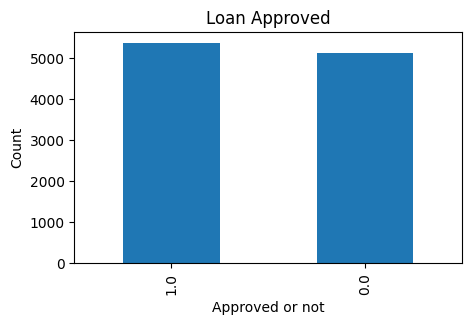

In [19]:
fig1 = plt.figure(figsize=(5, 3))
train_data['LoanApproved'].value_counts().plot(kind='bar')
plt.title('Loan Approved')
plt.xlabel('Approved or not')
plt.ylabel('Count')
plt.show()

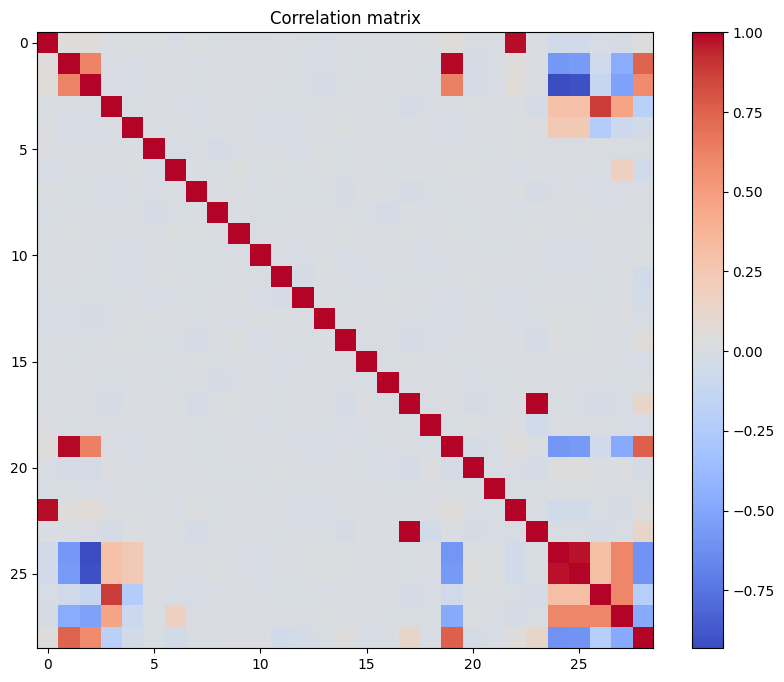

In [20]:
numeric_data = train_data.select_dtypes(include=[np.number])
fig2 = plt.figure(figsize=(10, 8))
corr_mat = numeric_data.corr()
plt.imshow(corr_mat, cmap='coolwarm')
plt.colorbar()
plt.title('Correlation matrix')
plt.show()

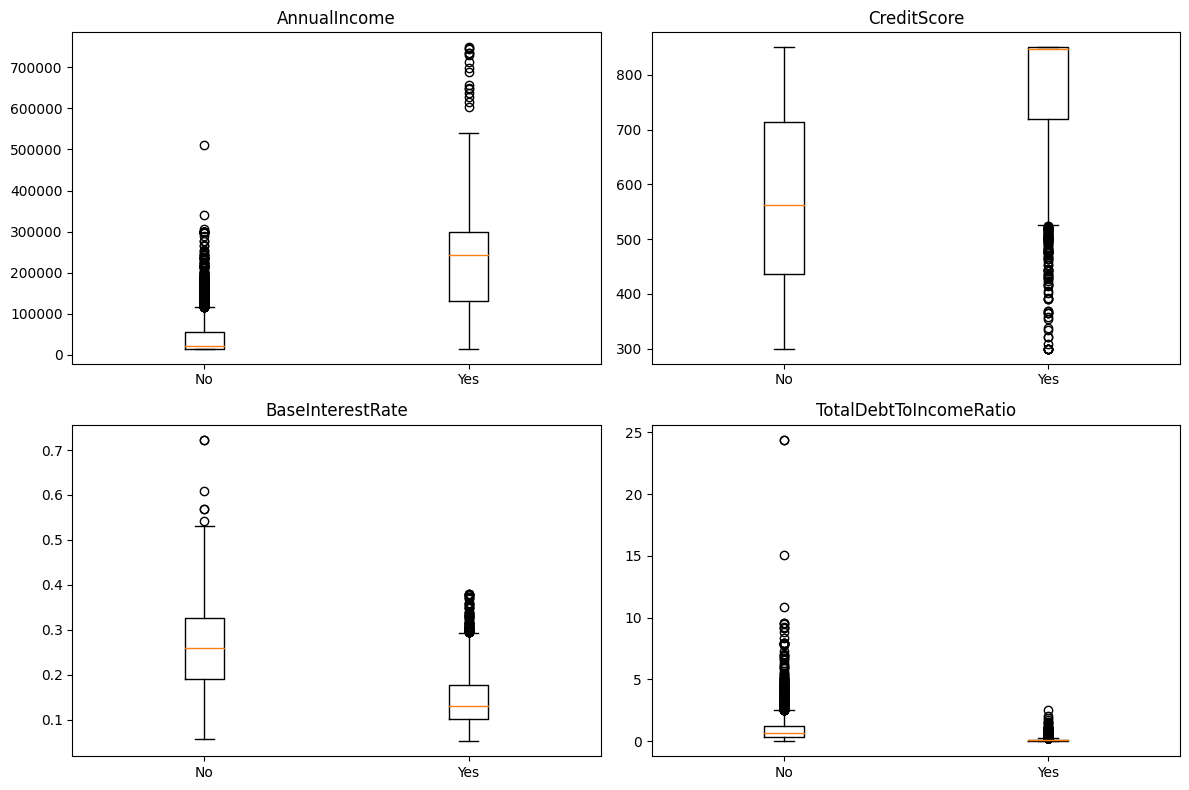

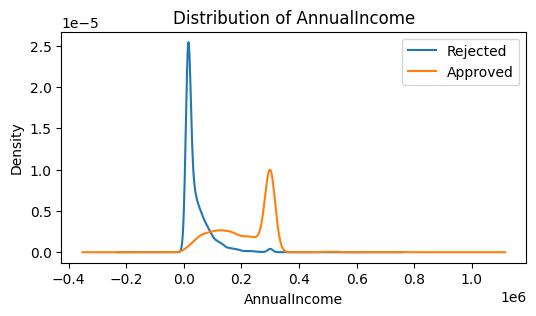

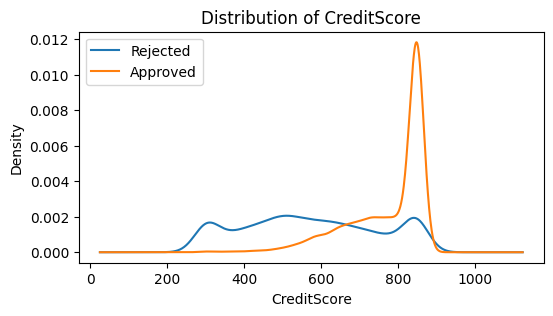

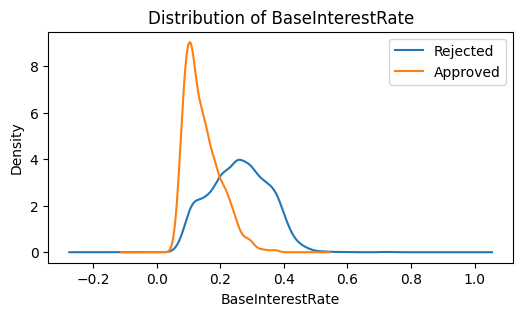

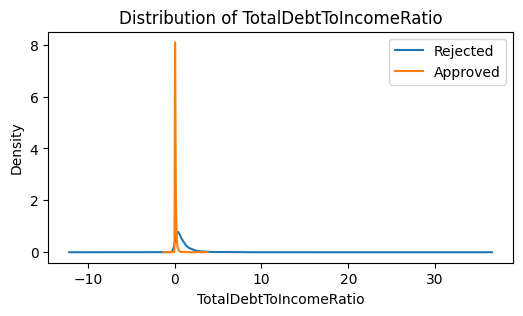

In [21]:
important_features = ['AnnualIncome', 'CreditScore', 'BaseInterestRate', 'TotalDebtToIncomeRatio']

fig3, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, feat in enumerate(important_features):
    row = idx // 2
    col = idx % 2
    approved_0 = train_data[train_data['LoanApproved'] == 0][feat]
    approved_1 = train_data[train_data['LoanApproved'] == 1][feat]
    axes[row, col].boxplot([approved_0.dropna(), approved_1.dropna()])
    axes[row, col].set_title(feat)
    axes[row, col].set_xticklabels(['No', 'Yes'])
fig3.tight_layout()
plt.show()

for feat in important_features:
    fig4 = plt.figure(figsize=(6, 3))
    train_data.groupby('LoanApproved')[feat].plot(kind='kde', legend=True)
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.legend(['Rejected', 'Approved'])
    plt.show()

In [22]:
X = train_data.drop('LoanApproved', axis=1)
y = train_data['LoanApproved']
y_not_null = y.notna()
X = X[y_not_null]
y = y[y_not_null]

X = pd.get_dummies(X)
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_test = test_data.copy()
X_test = pd.get_dummies(X_test)
X_test = X_test.reindex(columns=X.columns, fill_value=0)
X_test = X_test.fillna(X_test.median())
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
def my_accuracy(y_true, y_pred):
    y_true_np = y_true.values if hasattr(y_true, 'values') else y_true
    y_pred_np = y_pred.values if hasattr(y_pred, 'values') else y_pred
    
    correct = 0
    for i in range(len(y_true_np)):
        if y_true_np[i] == y_pred_np[i]:
            correct += 1
    return correct / len(y_true_np)

def my_precision(y_true, y_pred):
    y_true_np = y_true.values if hasattr(y_true, 'values') else y_true
    y_pred_np = y_pred.values if hasattr(y_pred, 'values') else y_pred
    
    tp = 0
    fp = 0
    for i in range(len(y_true_np)):
        if y_pred_np[i] == 1:
            if y_true_np[i] == 1:
                tp += 1
            else:
                fp += 1
    if tp + fp == 0:
        return 0
    return tp / (tp + fp)

def my_recall(y_true, y_pred):
    y_true_np = y_true.values if hasattr(y_true, 'values') else y_true
    y_pred_np = y_pred.values if hasattr(y_pred, 'values') else y_pred
    
    tp = 0
    fn = 0
    for i in range(len(y_true_np)):
        if y_true_np[i] == 1:
            if y_pred_np[i] == 1:
                tp += 1
            else:
                fn += 1
    if tp + fn == 0:
        return 0
    return tp / (tp + fn)

def my_f1(y_true, y_pred):
    p = my_precision(y_true, y_pred)
    r = my_recall(y_true, y_pred)
    if p + r == 0:
        return 0
    return 2 * p * r / (p + r)

test_y = np.array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])
test_pred = np.array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0])

print('Accuracy:')
print('My:', my_accuracy(test_y, test_pred))
print('Sklearn:', accuracy_score(test_y, test_pred))

print('\nPrecision:')
print('My:', my_precision(test_y, test_pred))
print('Sklearn:', precision_score(test_y, test_pred))

print('\nRecall:')
print('My:', my_recall(test_y, test_pred))
print('Sklearn:', recall_score(test_y, test_pred))

print('\nF1:')
print('My:', my_f1(test_y, test_pred))
print('Sklearn:', f1_score(test_y, test_pred))

Accuracy:
My: 0.5333333333333333
Sklearn: 0.5333333333333333

Precision:
My: 0.7
Sklearn: 0.7

Recall:
My: 0.6363636363636364
Sklearn: 0.6363636363636364

F1:
My: 0.6666666666666666
Sklearn: 0.6666666666666666


In [33]:
def my_auc_roc(true_labels, pred_probs):
    true_np = true_labels.values if hasattr(true_labels, 'values') else true_labels
    sorted_indices = np.argsort(pred_probs)[::-1]
    sorted_labels = true_np[sorted_indices]
    
    tpr_list = [0]
    fpr_list = [0]
    
    tp_count = 0
    fp_count = 0
    total_pos = np.sum(true_np)
    total_neg = len(true_np) - total_pos
    
    for i in range(len(sorted_labels)):
        if sorted_labels[i] == 1:
            tp_count += 1
        else:
            fp_count += 1
        
        tpr = tp_count / total_pos if total_pos > 0 else 0
        fpr = fp_count / total_neg if total_neg > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    area = 0
    for i in range(1, len(tpr_list)):
        width = fpr_list[i] - fpr_list[i-1]
        height = (tpr_list[i] + tpr_list[i-1]) / 2
        area += width * height
    
    return area

def my_auc_pr(true_labels, pred_probs):
    true_np = true_labels.values if hasattr(true_labels, 'values') else true_labels
    sorted_indices = np.argsort(pred_probs)[::-1]
    sorted_labels = true_np[sorted_indices]
    
    precision_list = [1.0]
    recall_list = [0.0]
    
    tp_count = 0
    fp_count = 0
    total_pos = np.sum(true_np)
    
    for i in range(len(sorted_labels)):
        if sorted_labels[i] == 1:
            tp_count += 1
        else:
            fp_count += 1
        
        precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
        recall = tp_count / total_pos if total_pos > 0 else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    area = 0
    for i in range(1, len(precision_list)):
        width = recall_list[i] - recall_list[i-1]
        height = (precision_list[i] + precision_list[i-1]) / 2
        area += width * height
    
    return area

Testing my bagging vs sklearn
Training my model...
Training sklearn model...

Results comparison:
AUC-ROC:
My: 0.9765988710428231
Sklearn: 0.9534105126862139

AUC-PR:
My: 0.9742073380047116
Sklearn: 0.9574714381993967

Accuracy:
My: 0.9204003813155386
Sklearn: 0.8727359389895138

Precision:
My: 0.9156736938588451
Sklearn: 0.8451668092386655

Recall:
My: 0.9301675977653632
Sklearn: 0.9199255121042831

F1:
My: 0.9228637413394919
Sklearn: 0.8809629959875167


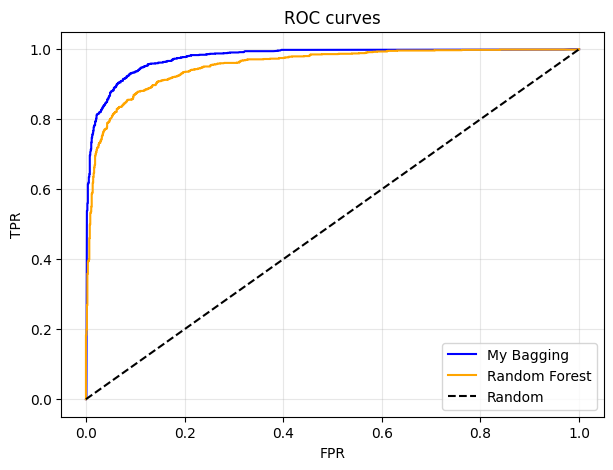

In [36]:
class MyBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=None, n_models=10, seed=42):
        self.base_model = base_model
        self.n_models = n_models
        self.seed = seed
        self.models_list = []
    
    def fit(self, X, y):
        np.random.seed(self.seed)
        n_samples = X.shape[0]
        self.models_list = []
        
        y_np = y.values if hasattr(y, 'values') else y
        
        for i in range(self.n_models):
            idx = np.random.choice(n_samples, size=n_samples, replace=True)
            X_boot = X[idx]
            y_boot = y_np[idx]
            
            if self.base_model is None:
                model = DecisionTreeClassifier(max_depth=10, random_state=self.seed+i)
            else:
                from sklearn.base import clone
                model = clone(self.base_model)
            
            model.fit(X_boot, y_boot)
            self.models_list.append(model)
        
        return self
    
    def predict_proba(self, X):
        all_probs = []
        for model in self.models_list:
            prob = model.predict_proba(X)[:, 1]
            all_probs.append(prob)
        
        all_probs = np.array(all_probs)
        avg_probs = np.mean(all_probs, axis=0)
        
        result = np.zeros((len(avg_probs), 2))
        result[:, 0] = 1 - avg_probs
        result[:, 1] = avg_probs
        return result
    
    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)

from sklearn.ensemble import RandomForestClassifier

print('Testing my bagging vs sklearn')

print('Training my model...')
my_bag = MyBaggingClassifier(n_models=20, seed=42)
my_bag.fit(X_train, y_train)
my_probs = my_bag.predict_proba(X_val)[:, 1]
my_preds = my_bag.predict(X_val)

print('Training sklearn model...')
sk_model = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
sk_model.fit(X_train, y_train)
sk_probs = sk_model.predict_proba(X_val)[:, 1]
sk_preds = sk_model.predict(X_val)

print('\nResults comparison:')
print('AUC-ROC:')
print('My:', my_auc_roc(y_val, my_probs))
print('Sklearn:', my_auc_roc(y_val, sk_probs))

print('\nAUC-PR:')
print('My:', my_auc_pr(y_val, my_probs))
print('Sklearn:', my_auc_pr(y_val, sk_probs))

y_val_np = y_val.values if hasattr(y_val, 'values') else y_val
my_preds_np = my_preds.values if hasattr(my_preds, 'values') else my_preds
sk_preds_np = sk_preds.values if hasattr(sk_preds, 'values') else sk_preds

print('\nAccuracy:')
print('My:', my_accuracy(y_val_np, my_preds_np))
print('Sklearn:', my_accuracy(y_val_np, sk_preds_np))

print('\nPrecision:')
print('My:', my_precision(y_val_np, my_preds_np))
print('Sklearn:', my_precision(y_val_np, sk_preds_np))

print('\nRecall:')
print('My:', my_recall(y_val_np, my_preds_np))
print('Sklearn:', my_recall(y_val_np, sk_preds_np))

print('\nF1:')
print('My:', my_f1(y_val_np, my_preds_np))
print('Sklearn:', my_f1(y_val_np, sk_preds_np))

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_my, tpr_my, _ = roc_curve(y_val, my_probs)
fpr_sk, tpr_sk, _ = roc_curve(y_val, sk_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr_my, tpr_my, label='My Bagging', color='blue')
plt.plot(fpr_sk, tpr_sk, label='Random Forest', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Testing my gradient boosting vs sklearn
Training my model...
Training sklearn model...

Results comparison:
AUC-ROC:
My: 0.9729881357658265
Sklearn: 0.9792357716480433

AUC-PR:
My: 0.9752087023238224
Sklearn: 0.9809605113949701

Accuracy:
My: 0.9108674928503336
Sklearn: 0.9223069590085796

Precision:
My: 0.9057639524245197
Sklearn: 0.9229340761374187

Recall:
My: 0.9217877094972067
Sklearn: 0.925512104283054

F1:
My: 0.913705583756345
Sklearn: 0.9242212924221291


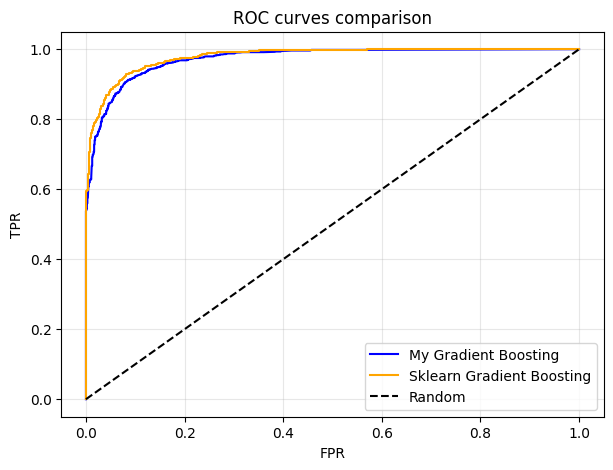

In [39]:
def sigmoid_func(x):
    return 1.0 / (1.0 + np.exp(-x))

class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=50, lr=0.1, tree_depth=3, seed=42):
        self.n_trees = n_trees
        self.lr = lr
        self.tree_depth = tree_depth
        self.seed = seed
        self.trees = []
        self.start_value = 0.0
    
    def fit(self, X, y):
        np.random.seed(self.seed)
        self.trees = []
        
        y_mean = np.mean(y)
        y_mean = np.clip(y_mean, 1e-7, 1-1e-7)
        self.start_value = np.log(y_mean / (1 - y_mean))
        
        current_pred = np.full(len(y), self.start_value)
        
        for i in range(self.n_trees):
            prob_pred = sigmoid_func(current_pred)
            residuals = y - prob_pred
            
            tree = DecisionTreeRegressor(max_depth=self.tree_depth, random_state=self.seed+i)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            tree_pred = tree.predict(X)
            current_pred += self.lr * tree_pred
        
        return self
    
    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.start_value)
        
        for tree in self.trees:
            pred += self.lr * tree.predict(X)
        
        prob = sigmoid_func(pred)
        result = np.zeros((len(prob), 2))
        result[:, 0] = 1 - prob
        result[:, 1] = prob
        return result
    
    def predict(self, X):
        prob = self.predict_proba(X)[:, 1]
        return (prob > 0.5).astype(int)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print('Testing my gradient boosting vs sklearn')

print('Training my model...')
my_gb = MyGradientBoostingClassifier(n_trees=50, lr=0.1, tree_depth=3, seed=42)
my_gb.fit(X_train, y_train)
my_gb_probs = my_gb.predict_proba(X_val)[:, 1]
my_gb_preds = my_gb.predict(X_val)

print('Training sklearn model...')
sk_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
sk_gb.fit(X_train, y_train)
sk_gb_probs = sk_gb.predict_proba(X_val)[:, 1]
sk_gb_preds = sk_gb.predict(X_val)

print('\nResults comparison:')
print('AUC-ROC:')
print('My:', my_auc_roc(y_val, my_gb_probs))
print('Sklearn:', my_auc_roc(y_val, sk_gb_probs))

print('\nAUC-PR:')
print('My:', my_auc_pr(y_val, my_gb_probs))
print('Sklearn:', my_auc_pr(y_val, sk_gb_probs))

y_val_np = y_val.values if hasattr(y_val, 'values') else y_val

print('\nAccuracy:')
print('My:', my_accuracy(y_val_np, my_gb_preds))
print('Sklearn:', my_accuracy(y_val_np, sk_gb_preds))

print('\nPrecision:')
print('My:', my_precision(y_val_np, my_gb_preds))
print('Sklearn:', my_precision(y_val_np, sk_gb_preds))

print('\nRecall:')
print('My:', my_recall(y_val_np, my_gb_preds))
print('Sklearn:', my_recall(y_val_np, sk_gb_preds))

print('\nF1:')
print('My:', my_f1(y_val_np, my_gb_preds))
print('Sklearn:', my_f1(y_val_np, sk_gb_preds))

fpr_my, tpr_my, _ = roc_curve(y_val, my_gb_probs)
fpr_sk, tpr_sk, _ = roc_curve(y_val, sk_gb_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr_my, tpr_my, label='My Gradient Boosting', color='blue')
plt.plot(fpr_sk, tpr_sk, label='Sklearn Gradient Boosting', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print('Step 1: Compare all boosting models to find the best one')

models_dict = {
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42, verbose=0),
    'SklearnGB': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MyGBM': my_gb
}

results = {}
for name, model in models_dict.items():
    if name != 'MyGBM':
        model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)
    results[name] = auc_score
    print(f'{name}: AUC-ROC = {auc_score:.5f}')

best_model_name = max(results, key=results.get)
best_auc = results[best_model_name]
print(f'\nBest model is: {best_model_name} with AUC-ROC = {best_auc:.5f}')

print('\nStep 2: Hyperparameter tuning for the best model')

if best_model_name == 'XGBoost':
    def xgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42
        }
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(xgb_objective, n_trials=10)
    
elif best_model_name == 'LightGBM':
    def lgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 800),
            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'random_state': 42,
            'verbose': -1
        }
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(lgb_objective, n_trials=10)

elif best_model_name == 'CatBoost':
    def cat_objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 200, 800),
            'depth': trial.suggest_int('depth', 4, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_state': 42,
            'verbose': 0
        }
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(cat_objective, n_trials=10)

elif best_model_name == 'SklearnGB':
    def sklearn_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': 42
        }
        model = GradientBoostingClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(sklearn_objective, n_trials=10)

elif best_model_name == 'MyGBM':
    def mygb_objective(trial):
        params = {
            'n_trees': trial.suggest_int('n_trees', 30, 100),
            'tree_depth': trial.suggest_int('tree_depth', 2, 6),
            'lr': trial.suggest_float('lr', 0.05, 0.2),
            'seed': 42
        }
        model = MyGradientBoostingClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(mygb_objective, n_trials=10)

print(f'\nBest parameters for {best_model_name}:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')
print(f'Best AUC-ROC: {study.best_value:.5f}')

print('\nStep 3: Train final model with best parameters')
if best_model_name == 'XGBoost':
    final_model = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
elif best_model_name == 'LightGBM':
    final_model = lgb.LGBMClassifier(**study.best_params, random_state=42, verbose=-1)
elif best_model_name == 'CatBoost':
    final_model = CatBoostClassifier(**study.best_params, random_state=42, verbose=0)
elif best_model_name == 'SklearnGB':
    final_model = GradientBoostingClassifier(**study.best_params, random_state=42)
elif best_model_name == 'MyGBM':
    final_model = MyGradientBoostingClassifier(**study.best_params)

final_model.fit(X_train, y_train)

final_val_pred = final_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, final_val_pred)
print(f'Final model AUC-ROC on validation: {final_auc:.5f}')

print('\nStep 4: Train on all data and create submission')
X_all = np.vstack([X_train, X_val])
y_all = np.concatenate([y_train, y_val])

if best_model_name == 'LightGBM':
    final_model_all = lgb.LGBMClassifier(**study.best_params, random_state=42, verbose=-1)
elif best_model_name == 'XGBoost':
    final_model_all = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
elif best_model_name == 'CatBoost':
    final_model_all = CatBoostClassifier(**study.best_params, random_state=42, verbose=0)
elif best_model_name == 'SklearnGB':
    final_model_all = GradientBoostingClassifier(**study.best_params, random_state=42)
elif best_model_name == 'MyGBM':
    final_model_all = MyGradientBoostingClassifier(**study.best_params)

final_model_all.fit(X_all, y_all)

test_pred = final_model_all.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    'Id': range(len(test_pred)),
    'LoanApproved': test_pred
})

filename = f'{best_model_name.lower()}_final_submission.csv'
submission.to_csv(filename, index=False)

submission.to_csv('my_best_kaggle_submission.csv', index=False)

print(f'\nSubmission saved to {filename}')
print('Also saved as: my_best_kaggle_submission.csv (use this for Kaggle)')
print('\nFirst 10 predictions:')
print(submission.head(10))

print('\nStep 5: Optimize and create submission for my GBM implementation')

def mygb_objective(trial):
    params = {
        'n_trees': trial.suggest_int('n_trees', 30, 100),
        'tree_depth': trial.suggest_int('tree_depth', 2, 6),
        'lr': trial.suggest_float('lr', 0.05, 0.2),
        'seed': 42
    }
    model = MyGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

my_study = optuna.create_study(direction='maximize')
my_study.optimize(mygb_objective, n_trials=5, show_progress_bar=False)

print(f'Best MyGBM AUC-ROC: {my_study.best_value:.5f}')

my_gbm_final = MyGradientBoostingClassifier(**my_study.best_params)
my_gbm_final.fit(X_all, y_all)
my_gbm_pred = my_gbm_final.predict_proba(X_test_scaled)[:, 1]

my_gbm_submission = pd.DataFrame({
    'Id': range(len(my_gbm_pred)),
    'LoanApproved': my_gbm_pred
})
my_gbm_submission.to_csv('my_gbm_submission.csv', index=False)

print('My GBM submission saved to: my_gbm_submission.csv')

Step 1: Compare all boosting models to find the best one
XGBoost: AUC-ROC = 0.98070
LightGBM: AUC-ROC = 0.98183
CatBoost: AUC-ROC = 0.97969
SklearnGB: AUC-ROC = 0.98033


[I 2025-12-14 17:39:25,812] A new study created in memory with name: no-name-0a490275-46d4-4958-b675-81a3bb622c22


MyGBM: AUC-ROC = 0.97284

Best model is: LightGBM with AUC-ROC = 0.98183

Step 2: Hyperparameter tuning for the best model


[I 2025-12-14 17:39:33,378] Trial 0 finished with value: 0.9824746130121043 and parameters: {'n_estimators': 579, 'num_leaves': 20, 'learning_rate': 0.06062607807506848, 'subsample': 0.9532369037253433, 'colsample_bytree': 0.940230470759537, 'min_child_samples': 18}. Best is trial 0 with value: 0.9824746130121043.
[I 2025-12-14 17:39:40,411] Trial 1 finished with value: 0.9827001134776536 and parameters: {'n_estimators': 247, 'num_leaves': 39, 'learning_rate': 0.058856752172334804, 'subsample': 0.648648115071246, 'colsample_bytree': 0.7559567243781886, 'min_child_samples': 11}. Best is trial 1 with value: 0.9827001134776536.
[I 2025-12-14 17:39:48,293] Trial 2 finished with value: 0.9828310492318435 and parameters: {'n_estimators': 435, 'num_leaves': 35, 'learning_rate': 0.03247646051762278, 'subsample': 0.8042941929985219, 'colsample_bytree': 0.8861977605226086, 'min_child_samples': 30}. Best is trial 2 with value: 0.9828310492318435.
[I 2025-12-14 17:39:56,425] Trial 3 finished with 


Best parameters for LightGBM:
  n_estimators: 791
  num_leaves: 55
  learning_rate: 0.15025264431472107
  subsample: 0.6278553860628415
  colsample_bytree: 0.9477352301601767
  min_child_samples: 40
Best AUC-ROC: 0.98330

Step 3: Train final model with best parameters
Final model AUC-ROC on validation: 0.98330

Step 4: Train on all data and create submission


[I 2025-12-14 17:41:07,793] A new study created in memory with name: no-name-46d7e6a8-3a40-47f5-b78a-3109c9299084



Submission saved to lightgbm_final_submission.csv
Also saved as: my_best_kaggle_submission.csv (use this for Kaggle)

First 10 predictions:
   Id  LoanApproved
0   0  1.000000e+00
1   1  7.131139e-11
2   2  1.000000e+00
3   3  1.000000e+00
4   4  1.000000e+00
5   5  6.430106e-11
6   6  1.000000e+00
7   7  1.000000e+00
8   8  9.463952e-01
9   9  9.345903e-14

Step 5: Optimize and create submission for my GBM implementation


[I 2025-12-14 17:47:03,859] Trial 0 finished with value: 0.9768634703794228 and parameters: {'n_trees': 100, 'tree_depth': 6, 'lr': 0.06499799072693568}. Best is trial 0 with value: 0.9768634703794228.
